In [33]:
import time
import os.path
import pickle
import pandas as pd
import mlflow
import numpy as np
from scipy.stats import uniform
from mlflow.models import infer_signature
from sklearn import set_config
from sklearn.feature_selection import r_regression
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [2]:
dataset = pd.read_csv('data/processed_english_lyrics.csv')

In [3]:
dataset = dataset[~dataset['lyrics'].isna()]
dataset['artist_tag_combination'] = dataset['artist'] + "#____#"+ dataset['tag']
dataset.columns

Index(['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'id',
       'language_cld3', 'language_ft', 'language', 'artist_tag_combination'],
      dtype='object')

In [4]:
dataset['tag'].value_counts()

tag
pop        1297956
rap         936110
rock        602160
rb          147248
country      83609
Name: count, dtype: int64

In this part we will use classical NLP methods for text classification:  
1) vectorize documents (lyrics) using TF-IDF vectorization method  
2) classify document vectors with Logistic Regression  

### Lyrics vectorization

TF-IDF vectorization a.k.a term frequence inverse document frequency encodes each unique word in the vocabulary with a real number from 0 to 1. The formula $tf*idf$.  
$tf$ - term frequency is calculated per document to identify how often word appears in the document  
$idf$ - inverse document frequency = $\dfrac{1}{frequency}$ of word across all documents  

In [5]:
X, y = dataset['lyrics'], dataset['tag']

In [6]:
def train_test_split_stratified_artist(df: pd.DataFrame, test_size: float = 0.10) -> tuple[pd.DataFrame, pd.Series, pd.Series]:
    """Function that splits the dataset in stratified fashion by artist to save tags distribution"""
    artist_tag_unique = sorted(df['artist_tag_combination'].unique())
    tags_list = list(map(lambda c: c.split("#____#")[1], artist_tag_unique))
    artist_tag_train, _, _, _ = train_test_split(artist_tag_unique,
                                                    tags_list,
                                                    test_size=test_size,
                                                    random_state=42,
                                                    stratify=tags_list)
    train_df = df[df['artist_tag_combination'].isin(artist_tag_train)]
    test_df = df[~df['artist_tag_combination'].isin(artist_tag_train)]
    X_test, y_test = test_df['lyrics'], test_df['tag']
    return (train_df, X_test, y_test)

#### Splitting data into 10/20/70 for test, validation and train datasets

In [7]:
train_validation_df, X_test, y_test = train_test_split_stratified_artist(dataset)
train_df, X_valid, y_valid = train_test_split_stratified_artist(train_validation_df, test_size=0.22)
X_train, y_train = train_df['lyrics'], train_df['tag']

In [8]:
del train_validation_df
del train_df

In [9]:
print('test len: ', len(X_test), len(y_test))
print('valid len: ', len(X_valid), len(y_valid))
print('train len: ', len(X_train), len(y_train))

test len:  307203 307203
valid len:  608271 608271
train len:  2151609 2151609


#### Testing pipeline parts individually and finding best hyper parameters. Than combining into one prediction pipeline.

In [34]:
VECTORIZER_NAME = 'vectorizer.pk'
SVD_NAME = 'svd.pk'
CLASSIFIER_NAME = 'logistic_regression.pk'
vectorizer_file_exists = os.path.isfile(VECTORIZER_NAME)
svd_file_exists = os.path.isfile(SVD_NAME)

Vectorizing text with TF-IDF

In [11]:
%%time
if not vectorizer_file_exists:
    start_time = time.time()
    vectorizer = TfidfVectorizer(stop_words='english',
                                 ngram_range=(1,2),
                                 max_features=200000,
                                 sublinear_tf=True,
                                 use_idf=True
                                )
    X_train_vectorized = vectorizer.fit_transform(X_train)
    with open(VECTORIZER_NAME, 'wb') as f:
        pickle.dump(vectorizer, f)
else:
    with open(VECTORIZER_NAME, 'rb') as f:
        vectorizer = pickle.load(f)
        X_train_vectorized = vectorizer.transform(X_train)
        
print(X_train_vectorized.shape)

(2151609, 200000)
CPU times: user 4min 52s, sys: 15 s, total: 5min 7s
Wall time: 5min 29s


Reducing dimensionality and sparsity with SVD

In [15]:
%%time
if not svd_file_exists:  
    svd = TruncatedSVD(n_components=200, n_iter=5, random_state=42)
    X_train_reduced = svd.fit_transform(X_train_vectorized)
    with open(SVD_NAME, 'wb') as f:
        pickle.dump(svd, f)
else:
    with open(SVD_NAME, 'rb') as f:
        svd = pickle.load(f)
    X_train_reduced = svd.transform(X_train_vectorized)
    
print(svd.explained_variance_ratio_.sum())
print(X_train_reduced.shape)

0.07229114989985684
(2151609, 200)
CPU times: user 12min 42s, sys: 2min 15s, total: 14min 58s
Wall time: 12min 28s


In [17]:
%%time
X_valid_vectorized = vectorizer.transform(X_valid)
X_valid_reduced = svd.transform(X_valid_vectorized)

CPU times: user 1min 30s, sys: 4.97 s, total: 1min 35s
Wall time: 2min 6s


Training Logistic Regression Model, for now hyperparameters are not optimized

In [23]:
%%time
distributions = dict(C=uniform(loc=0, scale=4),
                     l1_ratio=np.arange(0, 1, 0.2))
classifier = LogisticRegression(penalty='elasticnet',
                                class_weight='balanced',
                                solver='saga',
                                random_state=42,
                                warm_start=True,
                                n_jobs=-1)
clf = RandomizedSearchCV(classifier,
                         distributions,
                         random_state=42,
                         scoring='f1_macro',
                         cv=2,
                         verbose=3
                        )
search = clf.fit(np.concatenate([X_train_reduced,X_valid_reduced]), np.concatenate([y_train,y_valid]))
search.best_params_

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2] END ..C=1.49816047538945, l1_ratio=0.8;, score=0.440 total time= 4.9min
[CV 2/2] END ..C=1.49816047538945, l1_ratio=0.8;, score=0.425 total time= 6.1min
[CV 1/2] END C=0.7337391594646552, l1_ratio=0.8;, score=0.440 total time= 3.3min
[CV 2/2] END C=0.7337391594646552, l1_ratio=0.8;, score=0.425 total time= 4.0min
[CV 1/2] END .C=2.387400631785948, l1_ratio=0.2;, score=0.440 total time= 3.3min
[CV 2/2] END .C=2.387400631785948, l1_ratio=0.2;, score=0.425 total time= 3.9min
[CV 1/2] END C=0.6239780813448106, l1_ratio=0.4;, score=0.440 total time= 3.4min
[CV 2/2] END C=0.6239780813448106, l1_ratio=0.4;, score=0.425 total time= 4.0min
[CV 1/2] END C=1.8369955678634686, l1_ratio=0.8;, score=0.440 total time= 5.1min
[CV 2/2] END C=1.8369955678634686, l1_ratio=0.8;, score=0.425 total time= 7.1min
[CV 1/2] END .C=2.404460046972835, l1_ratio=0.4;, score=0.440 total time= 3.5min
[CV 2/2] END .C=2.404460046972835, l1_ratio=0.4;

{'C': 2.887995089067299, 'l1_ratio': 0.2}

In [24]:
start_time = time.time()
classifier = LogisticRegression(penalty='elasticnet',
                                class_weight='balanced',
                                solver='saga',
                                random_state=42,
                                warm_start=True,
                                n_jobs=-1,
                                l1_ratio=0.2,
                                C = 3)
classifier.fit(X_train_reduced, y_train)
print('Execution time: ', str((time.time()-start_time)/60), 'm')
print(classifier.score(X_train_reduced, y_train))

Execution time:  5.46710840066274 m
0.512068410199065


In [35]:
with open(CLASSIFIER_NAME, 'wb') as f:
    pickle.dump(classifier, f)

Transforming test dataset

In [36]:
%%time
X_test_vectorized = vectorizer.transform(X_test)
X_test_reduced = svd.transform(X_test_vectorized)

CPU times: user 46.3 s, sys: 3.57 s, total: 49.9 s
Wall time: 1min 13s


In [37]:
print(classification_report(y_test, classifier.predict(X_test_reduced)))

              precision    recall  f1-score   support

     country       0.12      0.66      0.21      8245
         pop       0.66      0.25      0.36    124753
         rap       0.90      0.80      0.85     97727
          rb       0.19      0.58      0.29     14610
        rock       0.45      0.61      0.52     61868

    accuracy                           0.52    307203
   macro avg       0.46      0.58      0.44    307203
weighted avg       0.66      0.52      0.54    307203



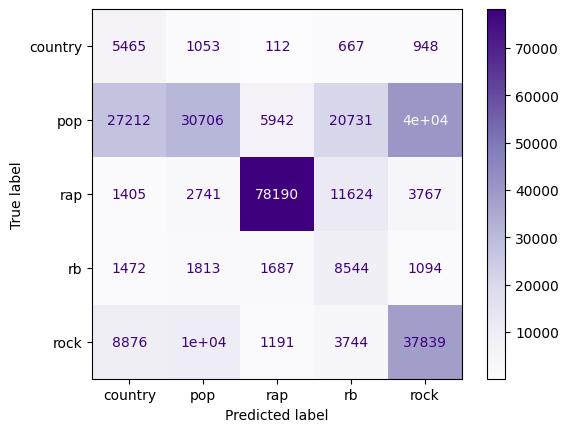

In [38]:
ConfusionMatrixDisplay.from_estimator(
    estimator = classifier,
    X=X_test_reduced,
    y=y_test,
    labels=classifier.classes_,
    cmap='Purples',
)

Explanation

In [47]:
len(X_train_vectorized.getcol(0).toarray())

2151609

In [ ]:
len(svd.components_[0][0])

Optimizing regularization params

In [4]:
X, y = dataset['lyrics'], dataset['tag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1), max_features=200000)
classifier = LogisticRegression(penalty='elasticnet', class_weight='balanced', random_state=42)

pipe = Pipeline(steps=[("vectorizer", vectorizer),
                       ("classifier", classifier)],
                memory='/Users/vtysch/sklearn_cache',
                verbose=True
               )

set_config(display='diagram')
display(pipe)

Pipeline(memory='/Users/vtysch/sklearn_cache',
         steps=[('vectorizer',
                 TfidfVectorizer(max_features=250000, ngram_range=1,
                                 stop_words='english')),
                ('classifier',
                 LogisticRegression(class_weight='balanced',
                                    penalty='elasticnet', random_state=42))],
         verbose=True)

In [ ]:
pipe.fit(X_train, y_train).score(X_test, y_test)